Used https://huggingface.co/course/chapter3/3?fw=tf as reference


In [ ]:
!pip install transformers
! pip install datasets


import sys
import numpy as np
import random as rn
import pandas as pd
import torchop

from torch import nn
# from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
clear_output()

In [ ]:
model_name = 'bert-base-uncased'
#here we need to tokenize the data so we can feed it into our model
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, DataCollatorWithPadding

from datasets import load_dataset
raw_datasets = load_dataset("imdb")

from datasets import DatasetDict
test_valid = raw_datasets["test"].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict

train = (raw_datasets["train"].shuffle()).shard(num_shards=4, index=0)
test = (test_valid["test"].shuffle()).shard(num_shards=4, index=0)
valid = (test_valid["train"].shuffle()).shard(num_shards=4, index=0)

datasets = DatasetDict({
    "train": (train),
    "test": (test),
    "valid": (valid)})
print(train["label"])
print(train["text"][:5])

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

[0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(set):
    return tokenizer(set["text"],  add_special_tokens=True, max_length = 512, truncation=True, padding =True)

tokenized_datasets = datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask","input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_datasets["valid"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)


Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3125 [00:00<?, ? examples/s]

Map:   0%|          | 0/3125 [00:00<?, ? examples/s]

In [ ]:
sentence = "Hi my name is anna. I like cats a lot"
haha = tokenizer(sentence, truncation=True, padding =True, return_attention_mask=True)

print(tokenizer.decode(haha["input_ids"]))

[CLS] hi my name is anna. i like cats a lot [SEP]


In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

batch_size = 8
num_epochs = 3
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

# Define a callback function to store the accuracy at every step. This will be called at every step to store the current accuracy of the BERT model
accuracy_list = []
accuracy_callback = tf.keras.callbacks.LambdaCallback(
    on_train_batch_end=lambda batch, logs: accuracy_list.append(logs['accuracy']) #Lambda funtion that appends accuracy to accuracy list at current step
)

model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'),
)
records = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    callbacks=[accuracy_callback] #This is where accuracy at every step is appended to accuracy_list

)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


782/782 [==============================] - 910s 1s/step - loss: 0.4102 - accuracy: 0.7995 - val_loss: 0.2129 - val_accuracy: 0.9152


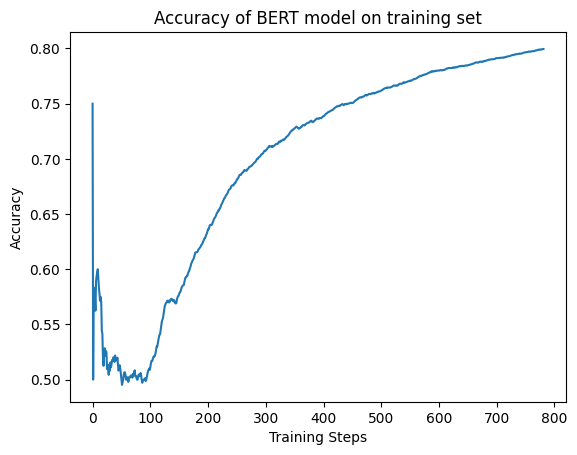

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list) #Accuracy of BERT on the training set for each training steps
plt.title("Accuracy of BERT model on training set")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
#Tokenizing the testing data-set
tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [ ]:
#Evaluating the loss/accuracy of our trained BERT model on the testing set
test_loss, test_accuracy = model.evaluate(tf_test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


391/391 [==============================] - 130s 332ms/step - loss: 0.2306 - accuracy: 0.9062
Test Loss: 0.23064687848091125
Test Accuracy: 0.9062399864196777


In [ ]:
#Choose the nth batch of 8 inputs that will be used to evaluate attention matrices and text relationships
Batch_index = 17

In [ ]:
#Batch of texts that will be used when evaluating attention matrices, here 8 represents the batch_size
#Texts are separated by an indent in the print

test_texts = tokenized_datasets["test"]['text'][ Batch_index * 8 : (Batch_index + 1) * 8]
test_texts[0] #Output first text as example

"Don't get me wrong, I assumed this movie would be stupid, I honestly did, I gave it an incredibly low standard to meet. The only reason I even saw it was because there were a bunch of girls going (different story for a different time). As I began watching I noticed something, this film was terrible. Now there are two types of terrible, there's Freddy vs. Jason terrible, where you and your friends sit back and laugh and joke about how terrible it is, and then there is a movie like this. The Cat in The Hat failed to create even a momentary interest in me. As I watched the first bit of it not only was I bored senseless, but I felt as though I had in some way been violated by the horrendousness of said movie. Mike Myers is usually brilliant, I love the majority of his work, but something in this movie didn't click. One of the things that the director/producers/writers/whatevers changed was that they refused to use any of the colors of the original book (red, black, white) on any character

In [ ]:
# Choose a transformer block and an attention head (starting from 0)
transformer_block = 1
attention_head = 2

#Accessing attention head number defined by here choosing
attention_number_correct = []
attention_number_incorrect = []

#This will hold whether a text is a good/bad prediction and why
text_labels = []


#inputs is a batch of 8 reviews with a max of 512 tokens (their count)
#labels is a 8 element array of 1 or 0 corresponding to the 8 reviews and their corresponding sentiment (tf.Tensor shape(8,))

# Loop through some examples in one batch of 8 samples the test dataset

for inputs, labels in tf_test_dataset.skip(Batch_index).take(1):


    #Get output object to get attention matrices for all inputs of the batch chosen by the batch_index defined earlier
    
    outputs = model(inputs, output_attentions=True)

    # Make predictions using the trained model
    predictions = model.predict(inputs) #TFSequenceClassifierOutput Object holding all the information of the predicitions
    logits = predictions.logits         #array of shape (8,2) where each row corresponds to an input of the batch_size, and the two dimensions are the
                                        #logistic scores for that input for the binary classification i.e row 1 = [2.32,-1.83] -> predicted class is 0

    predicted_labels = np.argmax(logits,axis=1) #Retrieve array of predicted label from logits  
    true_labels = labels.numpy()                #Retrieve true label array as numpy array


    #For each predictions in the batch

    for predicted_index, true_label in enumerate(true_labels):

      #Print text
      print(f'{test_texts[predicted_index]}')

      #If correct prediction
      if true_label == predicted_labels[predicted_index]:          
        result = "True Positive" if true_label else "True Negative"
        print(f"Correctly Predicted : {result}")
        attention_number_correct.append(predicted_index)
      #If incorrect prediction
      else:
        result = "False Negative" if true_label else "False Positive"
        print(f"Incorrectly Predicted : {result}")
        attention_number_incorrect.append(predicted_index)

      text_labels.append(result)


1/1 [==============================] - 0s 316ms/step
Don't get me wrong, I assumed this movie would be stupid, I honestly did, I gave it an incredibly low standard to meet. The only reason I even saw it was because there were a bunch of girls going (different story for a different time). As I began watching I noticed something, this film was terrible. Now there are two types of terrible, there's Freddy vs. Jason terrible, where you and your friends sit back and laugh and joke about how terrible it is, and then there is a movie like this. The Cat in The Hat failed to create even a momentary interest in me. As I watched the first bit of it not only was I bored senseless, but I felt as though I had in some way been violated by the horrendousness of said movie. Mike Myers is usually brilliant, I love the majority of his work, but something in this movie didn't click. One of the things that the director/producers/writers/whatevers changed was that they refused to use any of the colors of th

In [ ]:
Size_prediction = min(len(attention_number_correct),len(attention_number_incorrect))
#Number of samples for the batch_size that we will explore attention matrices (for correct and incorrect)
#If this number is 2, we will analyse 2 correct and 2 incorrect predictions and their attention matrices
Size_prediction

2

In [ ]:
#Contains all of the attention matrices for the inputs used in the analysis of attention matrices

outputs.attentions

(<tf.Tensor: shape=(8, 12, 512, 512), dtype=float32, numpy=
 array([[[[3.65678780e-03, 3.10199172e-03, 2.49020709e-03, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [1.69876926e-02, 3.18554579e-03, 2.03372701e-03, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [5.96200302e-03, 2.71725026e-03, 2.03120825e-03, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [4.70324361e-04, 3.13312071e-03, 1.23803993e-03, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [8.37113534e-04, 2.41579721e-03, 1.29807845e-03, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [6.02297718e-04, 3.35342786e-03, 2.19311961e-03, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[2.20807660e-02, 1.54978145e-04, 5.00901323e-03, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [2.68890499e-03, 1.68959075e-03, 1.68577104e

In [ ]:
###

#Output.attentions returns the attention matrices of the BERT model for the given input (chosen earlier by Batch_index). When accessing the output, we do
#so using outputs.attention[layer][attention_head][transformer_number]

#These three dimensions represent respectively:
 # - Which of the 12 layers of the BERT model we are accessing (layer)
 # - Which of the inputs from the Batch of inputs are we analyzing in the current layer
 # - Which of the transformer blocks (self-attention matrices) do we want to analyse in the current layer for the current input

###

#List that will hold the attention_matrices that will be analyzed
Correct_Attention_matrices = []
Incorrect_Attention_matrices = []

#Pick layer from 12 default layers in BERT model (0-11)
layer = 1
#Pick transformer from 12 transformers of the chosen layer (0-11)
transformer_number = 1
#For each of the correctly predicted text that will be analysed
for correct_index in attention_number_correct:
  Correct_Attention_matrices.append(outputs.attentions[layer][correct_index][transformer_number])
  if len(Correct_Attention_matrices) >= Size_prediction:
    break

#For each of the incorrectly predicted text that will be analysed
for incorrect_index in attention_number_incorrect:
  Incorrect_Attention_matrices.append(outputs.attentions[layer][incorrect_index][transformer_number])
  if len(Incorrect_Attention_matrices) >= Size_prediction:
    break

In [ ]:
Correct_Attention_matrices

[<tf.Tensor: shape=(512, 512), dtype=float32, numpy=
 array([[1.7476627e-01, 7.6932060e-03, 2.2108633e-02, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [2.2376212e-03, 1.3231361e-02, 3.4213838e-01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [7.5362786e-04, 1.2168233e-04, 1.5683349e-03, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [9.0123340e-03, 6.4023264e-04, 7.4510311e-04, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [1.0727453e-02, 3.3916102e-05, 1.0470694e-03, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [8.5778199e-03, 6.2404273e-05, 5.2262612e-06, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)>,
 <tf.Tensor: shape=(512, 512), dtype=float32, numpy=
 array([[1.8223323e-01, 1.4188460e-02, 1.9531360e-02, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [5.3589970e-02, 3.6689162e-03, 6.5531844e-01, ..., 0.0000

In [ ]:
Incorrect_Attention_matrices

[<tf.Tensor: shape=(512, 512), dtype=float32, numpy=
 array([[1.3772185e-01, 5.4991539e-03, 7.2431290e-03, ..., 3.6622682e-03,
         8.2207490e-03, 1.0941347e-02],
        [1.7660151e-01, 2.7875783e-02, 6.6976154e-01, ..., 1.7414695e-05,
         1.4086816e-05, 1.1581070e-03],
        [2.5229810e-02, 5.4754075e-03, 1.7006913e-02, ..., 3.0278527e-05,
         6.7527221e-06, 3.7705258e-04],
        ...,
        [3.5383359e-02, 2.7953390e-06, 1.1482111e-05, ..., 2.8290154e-04,
         3.5098797e-01, 6.9249538e-03],
        [5.2184448e-02, 8.8504567e-07, 1.4270461e-05, ..., 4.9952016e-04,
         1.2025714e-03, 5.3754258e-01],
        [7.8366274e-01, 1.8975998e-05, 7.9069332e-06, ..., 3.2349250e-03,
         1.4166621e-04, 3.4388684e-02]], dtype=float32)>,
 <tf.Tensor: shape=(512, 512), dtype=float32, numpy=
 array([[1.3293630e-01, 1.4546104e-02, 2.3671344e-02, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [2.4378790e-02, 1.1395779e-02, 8.4598380e-01, ..., 0.0000

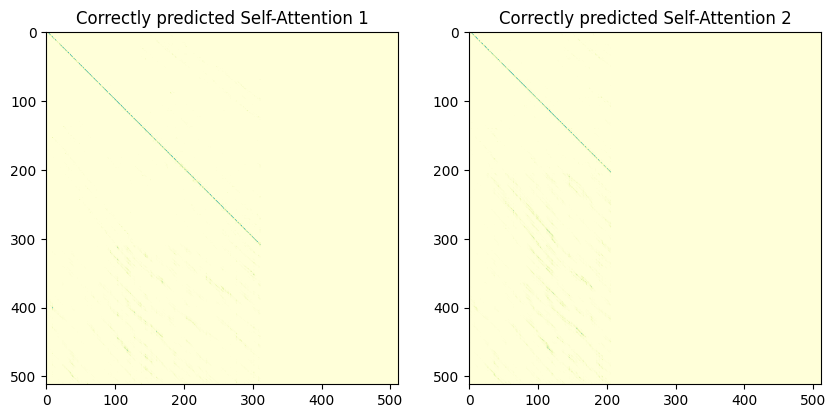

In [ ]:
# create subplots for each matrix
fig, axs = plt.subplots(1, len(Correct_Attention_matrices), figsize=(10, 5))

# plot each matrix in a subplot
for i, matrix in enumerate(Correct_Attention_matrices):

    axs[i].imshow(matrix, cmap='YlGnBu')
    axs[i].set_title(f"Correctly predicted Self-Attention {i+1}")

# display the plot
plt.show()


In [ ]:
Correct_tokens = []

#For the index of the correct_inputs
for correct_index in attention_number_correct[:Size_prediction]:

  #Tokens for current Matrix as a list
  current_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][correct_index])
  Correct_tokens.append(current_tokens)

  print(current_tokens)

['[CLS]', 'don', "'", 't', 'get', 'me', 'wrong', ',', 'i', 'assumed', 'this', 'movie', 'would', 'be', 'stupid', ',', 'i', 'honestly', 'did', ',', 'i', 'gave', 'it', 'an', 'incredibly', 'low', 'standard', 'to', 'meet', '.', 'the', 'only', 'reason', 'i', 'even', 'saw', 'it', 'was', 'because', 'there', 'were', 'a', 'bunch', 'of', 'girls', 'going', '(', 'different', 'story', 'for', 'a', 'different', 'time', ')', '.', 'as', 'i', 'began', 'watching', 'i', 'noticed', 'something', ',', 'this', 'film', 'was', 'terrible', '.', 'now', 'there', 'are', 'two', 'types', 'of', 'terrible', ',', 'there', "'", 's', 'freddy', 'vs', '.', 'jason', 'terrible', ',', 'where', 'you', 'and', 'your', 'friends', 'sit', 'back', 'and', 'laugh', 'and', 'joke', 'about', 'how', 'terrible', 'it', 'is', ',', 'and', 'then', 'there', 'is', 'a', 'movie', 'like', 'this', '.', 'the', 'cat', 'in', 'the', 'hat', 'failed', 'to', 'create', 'even', 'a', 'momentary', 'interest', 'in', 'me', '.', 'as', 'i', 'watched', 'the', 'first'

In [ ]:
#Set number of tokens that have largest contribution to score of text. Here, 3 means
#We will look at the 3 words (or pair of words) whose correlation affected the model's score
Biggest_contributor = 3

#For each correctly predicted matrix
for index, matrix in enumerate(Correct_Attention_matrices):

  matrix = matrix.numpy()

  largest_indices = np.argpartition(matrix, -Biggest_contributor, axis=None)[-Biggest_contributor:]

  # Convert the flattened indices into tuples of indices representing the coordinates of the largest values
  largest_coords = [np.unravel_index(i, matrix.shape) for i in largest_indices]


  #Get the tokens represented by these coordinates in the attention matrix
  tokens = Correct_tokens[index]

  #Print text being analysed (from list of texts in batch printed earlier)
  print(f'Text {attention_number_correct[index]} ({text_labels[attention_number_correct[index]]})\n')

  #For all pairs that contributed to the model's score the most
  for pairs in range(Biggest_contributor):
    #Get the pairs
    token1, token2 = tokens[largest_coords[pairs][0]], tokens[largest_coords[pairs][1]]

    #Get the appropriate text and corresponding pairs of tokens
    print(f'pair {pairs}: {token1}, {token2}')

  print('\n')

Text 0 (True Negative)

pair 0: i, felt
pair 1: or, not
pair 2: some, way


Text 3 (True Negative)

pair 0: better, than
pair 1: ', m
pair 2: do, with




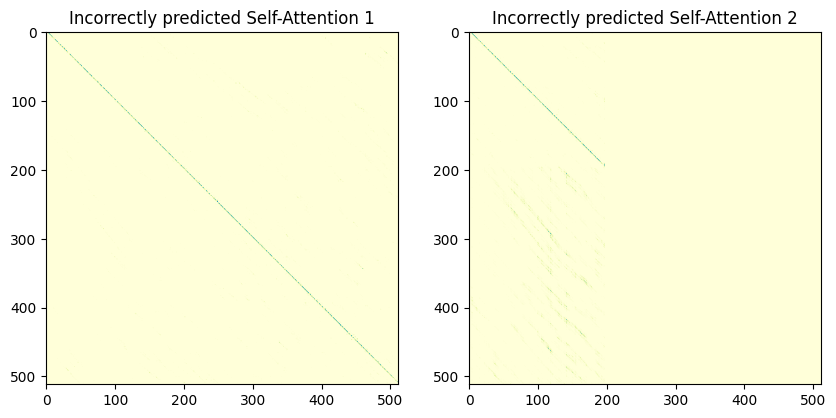

In [ ]:
# create subplots for each matrix
fig, axs = plt.subplots(1, len(Incorrect_Attention_matrices), figsize=(10, 5))

# plot each matrix in a subplot
for i, matrix in enumerate(Incorrect_Attention_matrices):

    axs[i].imshow(matrix, cmap='YlGnBu')
    axs[i].set_title(f"Incorrectly predicted Self-Attention {i+1}")

# display the plot
plt.show()


In [ ]:
Incorrect_tokens = []

#For the index of the correct_inputs
for incorrect_index in attention_number_incorrect[:Size_prediction]:

  #Tokens for current Matrix as a list
  current_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][incorrect_index])
  Incorrect_tokens.append(current_tokens)

  print(current_tokens)

['[CLS]', 'this', 'was', 'the', 'next', 'to', 'last', 'film', 'appearance', 'by', 'jill', 'ireland', ',', 'who', 'died', 'of', 'cancer', 'in', '1990', 'after', 'four', 'decades', 'as', 'a', 'well', '-', 'known', 'actress', 'and', 'producer', '.', 'ireland', 'made', 'quite', 'a', 'few', 'waves', 'in', 'the', 'press', 'when', 'she', 'dropped', 'her', 'then', '-', 'husband', 'david', 'mccall', '##um', 'in', '1967', ',', 'beginning', 'her', 'long', 'relationship', 'with', 'charles', 'bro', '##nson', '.', 'it', 'is', 'a', 'great', 'irony', 'that', 'bro', '##nson', ',', 'probably', 'the', 'all', '-', 'time', 'leader', 'in', 'number', 'of', 'deaths', 'rendered', 'on', '-', 'screen', ',', 'had', 'one', 'of', 'the', 'most', 'enduring', 'marriages', 'in', 'film', 'history', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', "'", 'assassination', "'", 'seems', 'to', 'be', 'a', 'movie', 'that', 'was', 'tucked', 'into', 'cannon', "'", 's', 'production', 'schedule', 'for', 'the', 'sake', 'of', 'bro', '#

In [ ]:
#For each incorrectly predicted matrix
for index, matrix in enumerate(Incorrect_Attention_matrices):

  matrix = matrix.numpy()

  largest_indices = np.argpartition(matrix, -Biggest_contributor, axis=None)[-Biggest_contributor:]

  # Convert the flattened indices into tuples of indices representing the coordinates of the largest values
  largest_coords = [np.unravel_index(i, matrix.shape) for i in largest_indices]


  #Get the tokens represented by these coordinates in the attention matrix
  tokens = Incorrect_tokens[index]

  #Print text being analysed (from list of texts in batch printed earlier)
  print(f'Text {attention_number_incorrect[index]} ({text_labels[attention_number_incorrect[index]]})\n')

  #For all pairs that contributed to the model's score the most
  for pairs in range(Biggest_contributor):
    #Get the pairs
    token1, token2 = tokens[largest_coords[pairs][0]], tokens[largest_coords[pairs][1]]

    #Get the appropriate text and corresponding pairs of tokens
    print(f'pair {pairs}: {token1}, {token2}')

  print('\n')



Text 1 (False Positive)

pair 0: in, 1967
pair 1: or, not
pair 2: one, another


Text 2 (False Positive)

pair 0: picked, off
pair 1: fast, paced
pair 2: an, excellent


